## Convert imaging data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from showit import image

In [3]:
import thunder

In [4]:
from numpy import array, concatenate
from os.path import join, exists
from os import mkdir, makedirs
import json

###Set directory and session information

In [5]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [6]:
key = '2016-04-06'
name = 'anm-0333650'

In [7]:
flatten = False
framesPerVolume = 1
nY = 512
nRoi = 2

In [8]:
flatten = False
framesPerVolume = 1
nY = 512
nRoi = 4

In [35]:
flatten = False
framesPerVolume = 2
nY = 2100
nRoi = 9

In [26]:
framesPerVolume = 2

Check if behavior data exists

In [9]:
path = join(directory, 'unprocessed', 'images', key, name)
print path
print exists(path)

/tier2/freeman/Nick/lfov.calibration/unprocessed/images/2016-04-06/anm-0333650
True


###Load file data

Each tiff file is automatically truncated to have integer number of volumes

In [14]:
thunder.images.fromtif?

In [15]:
data = thunder.images.fromtif(path + '/trial_00017_*.tif', nplanes=1, engine=sc)

In [16]:
data

Images
mode: spark
dtype: int16
shape: (213, 2390, 512)

###Reshape ROI data

In [ ]:
corrected = data

In [17]:
gap = (data.shape[1] - nY*nRoi)/(nRoi-1)

def split(oim):
    im = array([oim[nY*i + gap*i: nY*(i + 1) + gap*i, :] for i in range(nRoi)])
    return im.transpose(1, 2, 0)

In [38]:
order = [7, 6, 8, 5, 0, 4, 1, 3, 2]
gap = (data.shape[1] - nY*nRoi)/(nRoi-1)

def split(oim):
    im = [oim[nY*order[i] + gap*order[i]: nY*(order[i] + 1) + gap*order[i]] for i in range(nRoi)]
    return concatenate(im,axis=1)

In [18]:
corrected = thunder.images.fromrdd(data.tordd().mapValues(split))

In [16]:
corrected.s

Images
mode: spark
dtype: int16
shape: (17627, 512, 512, 2)

In [17]:
X = corrected[:17626].values.swapaxes(2,3).swapaxes(1,2).reshape(17626/2,2,2,512,512)
X = X.swap((1),())
X = X.reshape(8813,4,512,512)
X = thunder.images.fromrdd(X.tordd())

In [20]:
X = thunder.images.fromrdd(X.tordd())

In [46]:
corrected = corrected[:2968].values.reshape(2968/4,4,350,441)
corrected = corrected.swap((1),())
corrected = thunder.images.fromrdd(corrected.tordd(), )

In [21]:
corrected = X

In [19]:
corrected

Images
mode: spark
dtype: int16
shape: (213, 512, 512, 4)

###Save binary data

In [20]:
savepath = join(directory, 'processed', name, key, 'images')
if not exists(savepath):
    makedirs(savepath)

In [21]:
corrected.tobinary(savepath, overwrite=True)

Append number of volumes to conf.json

In [22]:
with open(savepath + '/conf.json') as path:
    conf = json.load(path)

In [23]:
conf['volumes'] = corrected.count()
conf['framesPerVolume'] = framesPerVolume

In [24]:
with open(savepath + '/conf.json', 'w') as path:
    json.dump(conf, path)

### Inspect data

In [25]:
mean = corrected.mean().toarray()

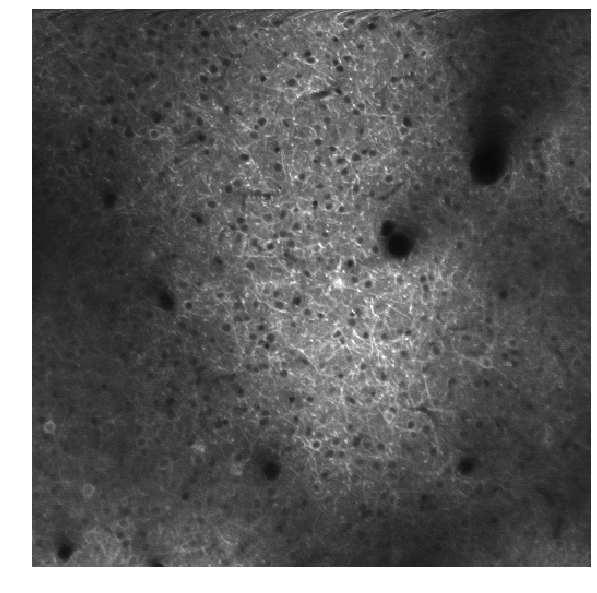

In [27]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(mean[:,:,1], clim=(0, 1140), ax=ax)